# Laboratorio 2
### Jonathan Espinoza 20022
### Juan Fernando Ramirez 20666

#### Categorización de peliculas por genero utilizando redes neuronales. 

In [239]:
import tensorflow as tf
import pandas as pd
import numpy as np
from scipy.stats import pointbiserialr
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [240]:
df = pd.read_csv('movie_statistic_dataset.csv')
df.head()

,movie_title,production_date,genres,runtime_minutes,director_name,director_professions,director_birthYear,director_deathYear,movie_averageRating,movie_numerOfVotes,approval_Index,Production budget $,Domestic gross $,Worldwide gross $
0,Avatar: The Way of Water,2022-12-09,"Action,Adventure,Fantasy",192.0,James Cameron,"writer,producer,director",1954,alive,7.8,277543.0,7.061101,460000000,667830256,2265935552
1,Avengers: Endgame,2019-04-23,"Action,Adventure,Drama",181.0,-,-,-,-,8.4,1143642.0,8.489533,400000000,858373000,2794731755
2,Pirates of the Caribbean: On Stranger Tides,2011-05-20,"Action,Adventure,Fantasy",137.0,Rob Marshall,"director,miscellaneous,producer",1960,alive,6.6,533763.0,6.272064,379000000,241071802,1045713802
3,Avengers: Age of Ultron,2015-04-22,"Action,Adventure,Sci-Fi",141.0,Joss Whedon,"writer,producer,director",1964,alive,7.3,870573.0,7.214013,365000000,459005868,1395316979
4,Avengers: Infinity War,2018-04-25,"Action,Adventure,Sci-Fi",149.0,-,-,-,-,8.4,1091968.0,8.460958,300000000,678815482,2048359754


In [241]:
df['genres_list'] = df['genres'].str.split(',')

genres_dummies = df['genres_list'].explode().str.get_dummies().sum(level=0)
df_movies_dummies = pd.concat([df, genres_dummies], axis=1)
df_movies_dummies.drop(['genres_list', 'genres', "\\N"], axis=1, inplace=True)

df_movies_dummies.columns
df_movies_dummies.head()



,movie_title,production_date,runtime_minutes,director_name,director_professions,director_birthYear,director_deathYear,movie_averageRating,movie_numerOfVotes,approval_Index,...,Music,Musical,Mystery,News,Romance,Sci-Fi,Sport,Thriller,War,Western
0,Avatar: The Way of Water,2022-12-09,192.0,James Cameron,"writer,producer,director",1954,alive,7.8,277543.0,7.061101,...,0,0,0,0,0,0,0,0,0,0
1,Avengers: Endgame,2019-04-23,181.0,-,-,-,-,8.4,1143642.0,8.489533,...,0,0,0,0,0,0,0,0,0,0
2,Pirates of the Caribbean: On Stranger Tides,2011-05-20,137.0,Rob Marshall,"director,miscellaneous,producer",1960,alive,6.6,533763.0,6.272064,...,0,0,0,0,0,0,0,0,0,0
3,Avengers: Age of Ultron,2015-04-22,141.0,Joss Whedon,"writer,producer,director",1964,alive,7.3,870573.0,7.214013,...,0,0,0,0,0,1,0,0,0,0
4,Avengers: Infinity War,2018-04-25,149.0,-,-,-,-,8.4,1091968.0,8.460958,...,0,0,0,0,0,1,0,0,0,0


In [242]:
professions = df_movies_dummies['director_professions'].str.split(',', expand=True).stack().unique()
professions = sorted(professions)

professions.remove('-')

for profession in professions:
    df_movies_dummies[f'director_is_{profession}'] = df_movies_dummies['director_professions'].str.contains(profession).astype(int)

In [243]:
df_movies_dummies['production_date'] = pd.to_datetime(df_movies_dummies['production_date'], errors='coerce')
df_movies_dummies['year'] = df_movies_dummies['production_date'].dt.year
df_movies_dummies['year'] = df_movies_dummies['year'].astype(int)

columns_to_drop = ['movie_title', 'director_name', 'director_professions', 'director_deathYear', 'director_birthYear', 'production_date']
df_movies_dummies = df_movies_dummies.drop(columns=columns_to_drop)


In [255]:

features = ['runtime_minutes', 'movie_averageRating', 'movie_numerOfVotes', 
               'approval_Index', 'Production budget $', 'Domestic gross $', 'Worldwide gross $']

for feature in features:
    mean = df_movies_dummies[feature].mean()
    std = df_movies_dummies[feature].std()
    df_movies_dummies[feature] = (df_movies_dummies[feature] - mean) / std
    
df_movies_dummies.head()

X = df_movies_dummies[['runtime_minutes', 'movie_averageRating', 'movie_numerOfVotes', 
               'approval_Index', 'Production budget $', 'Domestic gross $', 'Worldwide gross $']]

y = df_movies_dummies[['Action', 'Adventure', 'Animation', 'Biography',
       'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy',
       'Film-Noir', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News',
       'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War', 'Western']]

X = np.asarray(X)
y = np.asarray(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

y_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 1, 0, 0],
       [1, 0, 0, ..., 1, 0, 0]], dtype=int64)

In [245]:
X = np.asarray(X)
y = np.asarray(y)

X_train, X_test, y_train, y_test = train_test_split(
  X,
  y,
  test_size=0.20
)

In [262]:
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    BatchNormalization(),
    Dense(128, activation='relu',),
    Dropout(0.5),
    BatchNormalization(),
    Dense(64, activation='relu',),
    BatchNormalization(),
    Dense(32, activation='relu',),
    BatchNormalization(),
    Dense(y_train.shape[1], activation='sigmoid')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history1 = model.fit(X_train, y_train, epochs=200, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping])

test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Accuracy on test data: {test_accuracy}")

Epoch 1/200
55/55 [==============================] - 2s 6ms/step - loss: 8.6403 - accuracy: 0.1196 - val_loss: 7.4814 - val_accuracy: 0.2934
Epoch 2/200
55/55 [==============================] - 0s 3ms/step - loss: 7.9494 - accuracy: 0.2574 - val_loss: 6.9356 - val_accuracy: 0.3139
Epoch 3/200
55/55 [==============================] - 0s 3ms/step - loss: 7.7819 - accuracy: 0.3196 - val_loss: 6.9961 - val_accuracy: 0.3311
Epoch 4/200
55/55 [==============================] - 0s 3ms/step - loss: 8.0001 - accuracy: 0.3370 - val_loss: 7.3506 - val_accuracy: 0.3265
Epoch 5/200
55/55 [==============================] - 0s 3ms/step - loss: 8.1901 - accuracy: 0.3262 - val_loss: 7.9832 - val_accuracy: 0.3025
Epoch 6/200
55/55 [==============================] - 0s 3ms/step - loss: 8.4371 - accuracy: 0.3316 - val_loss: 8.4342 - val_accuracy: 0.3219
Epoch 7/200
55/55 [==============================] - 0s 3ms/step - loss: 8.7907 - accuracy: 0.3402 - val_loss: 9.3302 - val_accuracy: 0.2968
Epoch 8/200
5

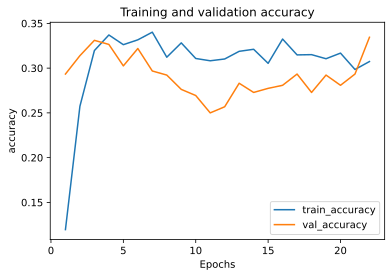

In [263]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

plot_metric(history1, 'accuracy')

In [268]:
model2 = Sequential([
    Dense(512, activation='sigmoid', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(512, activation='sigmoid',kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(256, activation='sigmoid', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(128, activation='sigmoid', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(64, activation='sigmoid', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(32, activation='sigmoid', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dense(y_train.shape[1], activation='sigmoid')
])

model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history2 = model2.fit(X_train, y_train, epochs=200, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping])

test_loss, test_accuracy = model2.evaluate(X_test, y_test, verbose=0)
print(f"Accuracy on test data: {test_accuracy}")

Epoch 1/200
55/55 [==============================] - 3s 14ms/step - loss: 9.4706 - accuracy: 0.1986 - val_loss: 9.0959 - val_accuracy: 0.1804
Epoch 2/200
55/55 [==============================] - 1s 11ms/step - loss: 9.2555 - accuracy: 0.2962 - val_loss: 8.9344 - val_accuracy: 0.1804
Epoch 3/200
55/55 [==============================] - 1s 10ms/step - loss: 9.5686 - accuracy: 0.3162 - val_loss: 8.5454 - val_accuracy: 0.1861
Epoch 4/200
55/55 [==============================] - 1s 11ms/step - loss: 9.8194 - accuracy: 0.3142 - val_loss: 8.2832 - val_accuracy: 0.2671
Epoch 5/200
55/55 [==============================] - 1s 10ms/step - loss: 10.0577 - accuracy: 0.3193 - val_loss: 8.4766 - val_accuracy: 0.3196
Epoch 6/200
55/55 [==============================] - 1s 11ms/step - loss: 10.1687 - accuracy: 0.3162 - val_loss: 9.0226 - val_accuracy: 0.3311
Epoch 7/200
55/55 [==============================] - 1s 11ms/step - loss: 10.5950 - accuracy: 0.3256 - val_loss: 9.7544 - val_accuracy: 0.3128
Epo

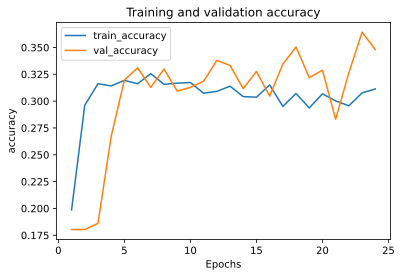

In [269]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

plot_metric(history2, 'accuracy')

In [270]:
model3 = Sequential([
    Dense(1024, activation='tanh', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(512, activation='tanh',kernel_regularizer=l1(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(512, activation='tanh', kernel_regularizer=l1(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(512, activation='tanh', kernel_regularizer=l1(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='tanh', kernel_regularizer=l1(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='tanh', kernel_regularizer=l1(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='tanh', kernel_regularizer=l1(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(32, activation='tanh', kernel_regularizer=l1(0.001)),
    BatchNormalization(),
    Dense(y_train.shape[1], activation='sigmoid')
])

model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history3 = model3.fit(X_train, y_train, epochs=200, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping])

test_loss, test_accuracy = model3.evaluate(X_test, y_test, verbose=0)
print(f"Accuracy on test data: {test_accuracy}")

Epoch 1/200
55/55 [==============================] - 4s 27ms/step - loss: 52.8352 - accuracy: 0.0802 - val_loss: 50.3747 - val_accuracy: 0.2580
Epoch 2/200
55/55 [==============================] - 1s 22ms/step - loss: 48.7616 - accuracy: 0.2035 - val_loss: 46.8113 - val_accuracy: 0.2740
Epoch 3/200
55/55 [==============================] - 1s 22ms/step - loss: 44.2671 - accuracy: 0.2725 - val_loss: 42.2416 - val_accuracy: 0.2820
Epoch 4/200
55/55 [==============================] - 1s 23ms/step - loss: 39.5973 - accuracy: 0.2888 - val_loss: 37.9758 - val_accuracy: 0.2991
Epoch 5/200
55/55 [==============================] - 1s 23ms/step - loss: 35.0625 - accuracy: 0.3148 - val_loss: 33.2424 - val_accuracy: 0.3584
Epoch 6/200
55/55 [==============================] - 1s 23ms/step - loss: 30.7215 - accuracy: 0.3279 - val_loss: 29.2950 - val_accuracy: 0.3345
Epoch 7/200
55/55 [==============================] - 1s 23ms/step - loss: 27.3172 - accuracy: 0.3211 - val_loss: 25.8908 - val_accuracy:

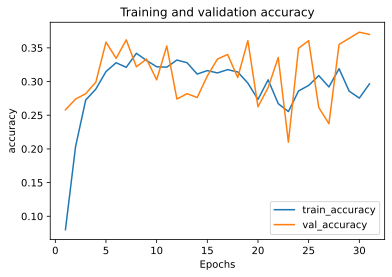

In [271]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

plot_metric(history3, 'accuracy')